# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [ ]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [ ]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 12.4 MB/s 


In [48]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### Testing

In [ ]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


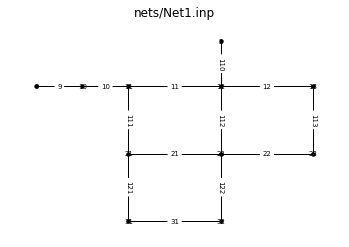

In [ ]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()

In [43]:
def gen_single_data(wdn, leakage_node='', end_time=30*24, include_time=False):

  # Labels
  y = np.zeros((end_time+1,))

  # Construct leakages
  leakages = []
  if leakage_node:
    leakage_start = np.random.randint(end_time // 2, end_time * 9 // 10)
    leakage_strength = round(0.0009 + np.random.rand() / 2000, 4)
    leakages.append((leakage_node, leakage_strength, leakage_start+10*24, end_time+10*24))
    y[leakage_start:] = 1
  
  # Run simulation and remove first 10 convergence days
  p = wdn.simulate(end_time+10*24, leakages)[10*24:]

  # Add noise
  noise = np.random.normal(0, 0.15, [len(p), len(wdn.important_nodes)])
  p.loc[:, wdn.important_nodes] = p.loc[:, wdn.important_nodes] + noise

  # Features
  data = Dataloader(p, wdn.important_nodes)
  X = data.get_nodes(include_time=include_time)
  print(X.columns)

  return X, y

In [ ]:
def show_data(X, y):
  # Get Leakage time
  leakage_at = round(30*24 - y.sum())
  print('Leakage at', 240+leakage_at, 'Day', leakage_at // 24, 'Hour', leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[240+leakage_at-3*24:leakage_at+240+3*24,:], line_at=[240+leakage_at])

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy)

             10         11         12  ...    9  hour of the day  day
hour                                   ...                           
240   78.624117  78.218472  81.975738  ...  0.0                0   10
241   77.446787  77.401699  80.855486  ...  0.0                1   10
242   75.900238  75.800724  79.279923  ...  0.0                2   10
243   87.695954  81.426636  79.971326  ...  0.0                3   10
244   87.909647  81.730576  80.781794  ...  0.0                4   10
...         ...        ...        ...  ...  ...              ...  ...
956   91.135146  85.161871  83.115793  ...  0.0               20   39
957   91.803574  86.296412  84.261715  ...  0.0               21   39
958   92.012280  86.420706  84.830783  ...  0.0               22   39
959   92.546955  87.040335  85.302091  ...  0.0               23   39
960   92.427165  86.978411  85.670012  ...  0.0                0   40

[721 rows x 13 columns]
Nodelist:
['23', '13', '32', '10', '12', '22', '21', '11', '31', 

<Figure size 432x288 with 0 Axes>

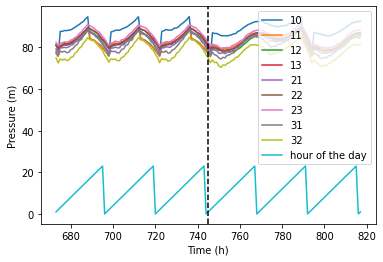

<Figure size 432x288 with 0 Axes>

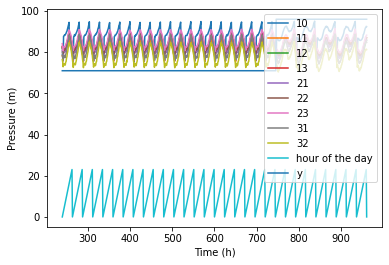

In [46]:
X, y = gen_single_data(wdn, '12', include_time=True)
show_data(X, y)

In [ ]:
X.columns

Index(['21', '12', '32', '23', '13', '22', '10', '31', '11', 'hour of the day',
       'hour of the day'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
from sklearn import svm

# Create the model
model = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[109,  12],
       [ 23,  37]])

ohne tod: array([[77, 26],
       [34, 44]])